# Calibrate Cameras
[https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html](https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html)

In [2]:
from models.dataset.dataset_container import DatasetContainer
from matplotlib import pyplot as plt
from pathlib import Path
import cv2

In [3]:
resource_path = Path("../../resources")

In [44]:
dataset_container = DatasetContainer()
dataset_container.load_from_dataset(resource_path / Path("images/uncalibrated/c_dataset_small_near_1.npz"))

True

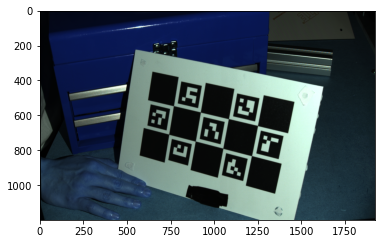

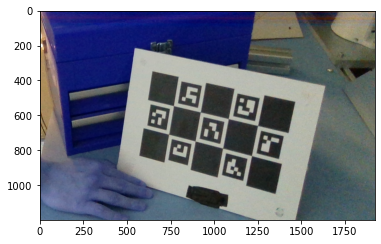

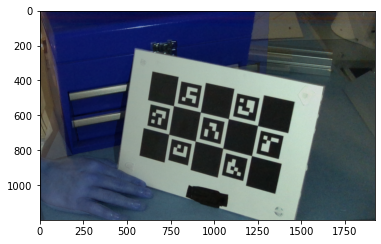

In [45]:
import numpy as np

idx = 0
img_2 = dataset_container.realsense.rgb[idx]
img_1 = dataset_container.zivid.rgb[idx]

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_1, None)
kp2, des2 = sift.detectAndCompute(img_2, None)

index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m,n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
#-- Draw matches
img_matches = np.empty((max(img_1.shape[0], img_2.shape[0]), img_1.shape[1]+img_2.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(img_1, kp1, img_2, kp2, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#-- Localize the object
obj = np.empty((len(good_matches),2), dtype=np.float32)
scene = np.empty((len(good_matches),2), dtype=np.float32)
for i in range(len(good_matches)):
    #-- Get the keypoints from the good matches
    obj[i,0] = kp1[good_matches[i].queryIdx].pt[0]
    obj[i,1] = kp1[good_matches[i].queryIdx].pt[1]
    scene[i,0] = kp2[good_matches[i].trainIdx].pt[0]
    scene[i,1] = kp2[good_matches[i].trainIdx].pt[1]
H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
#-- Get the corners from the image_1 ( the object to be "detected" )
obj_corners = np.empty((4,1,2), dtype=np.float32)
obj_corners[0,0,0] = 0
obj_corners[0,0,1] = 0
obj_corners[1,0,0] = img_1.shape[1]
obj_corners[1,0,1] = 0
obj_corners[2,0,0] = img_1.shape[1]
obj_corners[2,0,1] = img_1.shape[0]
obj_corners[3,0,0] = 0
obj_corners[3,0,1] = img_1.shape[0]
scene_corners = cv2.perspectiveTransform(obj_corners, H)
#-- Draw lines between the corners (the mapped object in the scene - image_2 )
cv2.line(img_matches, (int(scene_corners[0,0,0] + img_1.shape[1]), int(scene_corners[0,0,1])),\
    (int(scene_corners[1,0,0] + img_1.shape[1]), int(scene_corners[1,0,1])), (0,255,0), 4)
cv2.line(img_matches, (int(scene_corners[1,0,0] + img_1.shape[1]), int(scene_corners[1,0,1])),\
    (int(scene_corners[2,0,0] + img_1.shape[1]), int(scene_corners[2,0,1])), (0,255,0), 4)
cv2.line(img_matches, (int(scene_corners[2,0,0] + img_1.shape[1]), int(scene_corners[2,0,1])),\
    (int(scene_corners[3,0,0] + img_1.shape[1]), int(scene_corners[3,0,1])), (0,255,0), 4)
cv2.line(img_matches, (int(scene_corners[3,0,0] + img_1.shape[1]), int(scene_corners[3,0,1])),\
    (int(scene_corners[0,0,0] + img_1.shape[1]), int(scene_corners[0,0,1])), (0,255,0), 4)
#-- Show detected matches

plt.figure(2)
plt.imshow(img_1)
cv2.imwrite("zivid.png", img_1)

img_2_warp = cv2.warpPerspective(img_2, np.linalg.inv(H), (1920, 1200))
plt.figure(3)
plt.imshow(img_2_warp)
cv2.imwrite("realsense.png", img_2_warp)

img_both = cv2.addWeighted(img_1, 0.5, img_2_warp, 0.5, 0)
plt.figure(4)
plt.imshow(img_both)
cv2.imwrite("both.png", img_both)
# cv2.imwrite("test.png", img_matches)
# cv2.imwrite("test_warp.png", img_2_warp)
# cv2.imwrite("test_zivid.png", img_1)